In [1]:
import numpy as np
import os

# this is for loading the data
def load_fall_X(file_name):
    temp = np.memmap(file_name, dtype='float32', mode='r')
    X = np.reshape(temp, [-1, 256, 6])
    return X

# this is for loading the labels (one-hot encoding: [1, 0, 0]-->nonfall, [0, 1, 0]-->pre-impact fall, [0, 0, 1]-->fall	
def load_fall_y(file_name):
    temp = np.memmap(file_name, dtype='int8', mode='r')
    y= np.reshape(temp, [-1, 3])
    return y

def dset_fpath(fname):
    _fp = os.path.abspath('.')
    _hp = "wobblewatch"
    _fp = _fp.split(_hp)[0]
    return os.path.abspath("%s/%s/data/sisfall/preproc/%s" % (_fp, _hp, fname))

In [2]:
test  = {'X': {}, 'y': {}}
train = {'X': {}, 'y': {}}
for i in range(5):
    test['X'][i] = load_fall_X(dset_fpath("test_x_%i" % i))
    test['y'][i] = load_fall_y(dset_fpath("test_y_%i" % i))
    train['X'][i] = load_fall_X(dset_fpath("train_x_%i" % i))
    train['y'][i] = load_fall_y(dset_fpath("train_y_%i" % i))

In [3]:
for i in range(5):
    print("Set", i)
    print(" X train shape:", train['X'][i].shape)
    print(" y train shape:", train['y'][i].shape)
    print(" X test shape: ", test['X'][i].shape)
    print(" y test shape: ", test['y'][i].shape)

Set 0
 X train shape: (75025, 256, 6)
 y train shape: (75025, 3)
 X test shape:  (19064, 256, 6)
 y test shape:  (19064, 3)
Set 1
 X train shape: (73347, 256, 6)
 y train shape: (73347, 3)
 X test shape:  (20742, 256, 6)
 y test shape:  (20742, 3)
Set 2
 X train shape: (73534, 256, 6)
 y train shape: (73534, 3)
 X test shape:  (20555, 256, 6)
 y test shape:  (20555, 3)
Set 3
 X train shape: (77296, 256, 6)
 y train shape: (77296, 3)
 X test shape:  (16793, 256, 6)
 y test shape:  (16793, 3)
Set 4
 X train shape: (77154, 256, 6)
 y train shape: (77154, 3)
 X test shape:  (16935, 256, 6)
 y test shape:  (16935, 3)


In [ ]:
train['y']

In [ ]:
y = train['y'][0]
print(y)
y[y[:,0] == 0]

In [ ]:
import matplotlib.pyplot as plt

setnum = 0


col_start = {"acc": 0, "rot": 3}
col = col_start['rot']
X, y = train['X'][setnum], train['y'][setnum]
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)
labeli = 1
labelj = 1
X_fpf, y_fpf = X[y[:,labeli] == labelj], y[y[:,labeli] == labelj]
print(X_fpf.shape, y_fpf.shape)

# for index in range(len(X_fpf)):
for index in range(5):
    _X = X[index]
#     print(_X.shape)
    plt.plot(_X[:,col])
    plt.plot(_X[:,col+1])
    plt.plot(_X[:,col+2])
    plt.show()
    
X_fpf, y_fpf = X[y[:,0] == 0], y[y[:,0] == 0]

In [22]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow_addons import losses 
import matplotlib.pyplot as plt

n_timesteps = 256
n_features = 6
n_outputs = 3

def cnn_model():

    model = models.Sequential()

    model.add(layers.Conv1D(kernel_size=3, 
                            filters=64, 
                            activation='relu', 
                            input_shape=(n_timesteps, n_features)))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv1D(kernel_size = 3, 
                            filters = 64, 
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv1D(kernel_size = 3, 
                            filters = 64, 
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(60))
    model.add(layers.Dropout(0.5))

    # model.add(layers.Conv1D(kernel_size = 1, 
    #                         filters = 1920, 
    #                         activation='relu'))

    # model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512))

    model.add(layers.Dense(n_outputs, activation='softmax'))

    print(model.summary())

    opt = optimizers.Nadam(learning_rate=0.0005)
    lss = losses.SigmoidFocalCrossEntropy()
#     lss = losses.focal_loss()
    model.compile(loss=lss, optimizer=opt, metrics=['accuracy'])    


    
    return model

## Next I run the 5-fold cross-validation.

In [9]:
n_folds = 5
n_epochs = 20
batch_size = 64
history = {}
mod = {}
for fold in range(n_folds):
    X_train, y_train = train['X'][fold], train['y'][fold]
    X_test,  y_test  =  test['X'][fold],  test['y'][fold]
    mod[fold] = cnn_model()
    history[fold] = mod[fold].fit(train['X'][fold], train['y'][fold], 
                                  validation_data=(test['X'][fold], test['y'][fold]), 
                                  epochs = n_epochs, batch_size = batch_size )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 254, 64)           1216      
_________________________________________________________________
batch_normalization_3 (Batch (None, 254, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 127, 64)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 127, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 125, 64)           12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 125, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 62, 64)           

Epoch 7/20
1147/1147 [==============================] - 43s 37ms/step - loss: 0.0282 - accuracy: 0.6666 - val_loss: 0.0289 - val_accuracy: 0.6667
Epoch 8/20
1147/1147 [==============================] - 39s 34ms/step - loss: 0.0281 - accuracy: 0.6667 - val_loss: 0.0291 - val_accuracy: 0.6667
Epoch 9/20
1147/1147 [==============================] - 42s 37ms/step - loss: 0.0282 - accuracy: 0.6666 - val_loss: 0.0291 - val_accuracy: 0.6667
Epoch 10/20
1147/1147 [==============================] - 42s 36ms/step - loss: 0.0279 - accuracy: 0.6667 - val_loss: 0.0291 - val_accuracy: 0.6667
Epoch 11/20
1147/1147 [==============================] - 42s 37ms/step - loss: 0.0278 - accuracy: 0.6667 - val_loss: 0.0290 - val_accuracy: 0.6667
Epoch 12/20
1147/1147 [==============================] - 41s 36ms/step - loss: 0.0278 - accuracy: 0.6667 - val_loss: 0.0291 - val_accuracy: 0.6667
Epoch 13/20
1147/1147 [==============================] - 41s 35ms/step - loss: 0.0277 - accuracy: 0.6667 - val_loss: 0.02

1208/1208 [==============================] - 42s 35ms/step - loss: 0.0700 - accuracy: 0.6634 - val_loss: 0.1004 - val_accuracy: 0.6659
Epoch 2/20
1208/1208 [==============================] - 38s 31ms/step - loss: 0.0463 - accuracy: 0.6650 - val_loss: 0.0458 - val_accuracy: 0.6667
Epoch 3/20
1208/1208 [==============================] - 41s 34ms/step - loss: 0.0342 - accuracy: 0.6659 - val_loss: 0.0327 - val_accuracy: 0.6666
Epoch 4/20
1208/1208 [==============================] - 42s 35ms/step - loss: 0.0329 - accuracy: 0.6659 - val_loss: 0.0301 - val_accuracy: 0.6667
Epoch 5/20
1208/1208 [==============================] - 41s 34ms/step - loss: 0.0286 - accuracy: 0.6666 - val_loss: 0.0297 - val_accuracy: 0.6667
Epoch 6/20
1208/1208 [==============================] - 42s 34ms/step - loss: 0.0286 - accuracy: 0.6666 - val_loss: 0.0294 - val_accuracy: 0.6667
Epoch 7/20
1208/1208 [==============================] - 41s 34ms/step - loss: 0.0282 - accuracy: 0.6667 - val_loss: 0.0293 - val_accura

In [14]:
for fold in mod:
    test_loss, test_acc = mod[fold].evaluate(test['X'][fold], test['y'][fold], verbose = 2)

596/596 - 3s - loss: 0.0272 - accuracy: 0.6667
649/649 - 3s - loss: 0.0292 - accuracy: 0.6667
643/643 - 3s - loss: 0.0260 - accuracy: 0.6667
525/525 - 2s - loss: 0.0292 - accuracy: 0.6667
530/530 - 2s - loss: 0.0280 - accuracy: 0.6667


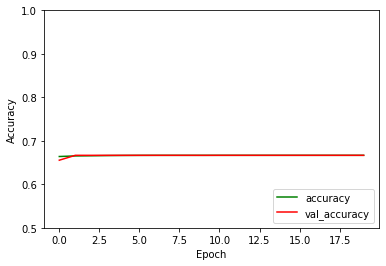

In [17]:
acc,vacc = [],[]
for fold in history:
    acc.append(history[fold].history['accuracy'])
    vacc.append(history[fold].history['val_accuracy'])
plt.plot(np.mean(acc, axis=0), label='accuracy', color='green')
plt.plot(np.mean(vacc, axis=0), label = 'val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

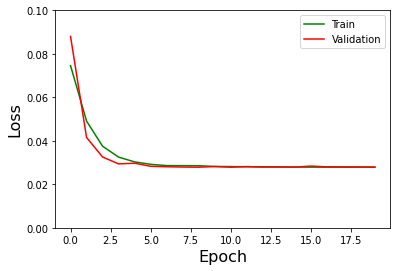

In [19]:
loss,vloss = [],[]
for fold in history:
    loss.append(history[fold].history['loss'])
    vloss.append(history[fold].history['val_loss'])
    
plt.plot(np.mean(loss, axis=0), label='Train', color='green')
plt.plot(np.mean(vloss, axis=0), label='Validation', color='red')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.ylim([0., 0.1])
plt.legend(loc='upper right')
plt.show()

Now let's look at the validation.

In [34]:
mod.keys()
a = np.array([[[1,2,3]],[[4,5,6]]])
print(a.shape)
a.reshape((2,3)).shape

(2, 1, 3)


(2, 3)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
# X_train, y_train = train['X'][fold], train['y'][fold]
# X_test,  y_test  =  test['X'][fold],  test['y'][fold]
ypm, ytm = [], []
for fold in mod:
    y_pred = mod[fold].predict(test['X'][fold])
    y_pred = y_pred.reshape((y_pred.shape[0],y_pred.shape[-1]))
    y_pred_max = np.argmax(y_pred, axis=1)
    y_test_max = np.argmax(test['y'][fold], axis=1)
    if len(ypm) == 0:
        ypm = y_pred_max
        ytm = y_test_max
    else:
        ypm = np.concatenate((ypm,y_pred_max))
        ytm = np.concatenate((ytm,y_test_max))
    print(y_pred.shape, y_pred_max.shape, y_test_max.shape)
#     print(classification_report(y_test_max, y_pred_max, target_names=['no fall', 'pre-fall', 'fall']))
#     print(confusion_matrix(y_test_max, y_pred_max))
#    confusion_matrix(y_test_max, y_pred_max)
#     print(classification_report(y_test_max, y_pred_max, target_names=['no fall', 'pre-fall', 'fall']))
print("\nOverall\n")
print(classification_report(ytm, ypm, target_names=['no fall', 'pre-fall', 'fall']))
print(confusion_matrix(ytm, ypm))

(19064, 3) (19064,) (19064,)
(20742, 3) (20742,) (20742,)
(20555, 3) (20555,) (20555,)
(16793, 3) (16793,) (16793,)
(16935, 3) (16935,) (16935,)

Overall

              precision    recall  f1-score   support

     no fall       0.98      1.00      0.99     92149
    pre-fall       0.00      0.00      0.00      1084
        fall       0.00      0.00      0.00       856

    accuracy                           0.98     94089
   macro avg       0.33      0.33      0.33     94089
weighted avg       0.96      0.98      0.97     94089

[[92149     0     0]
 [ 1084     0     0]
 [  856     0     0]]


/home/apatch/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Metrics for classification

\begin{align}
\text{Sensitivity} &= \frac{\text{TP}}{\text{TP} + \text{FN}} \\
\text{Specificity} &= \frac{\text{TN}}{\text{TN} + \text{FP}} \\
\text{Accuracy} &= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}} \\
\end{align}

In [ ]:
def truth_test(_test,_pred, i):
    _test = np.array(_test)
    _pred = np.array(_pred)
    
    _pred_pos = _test[_pred == i]
    _pred_neg = _test[_pred != i]
    
    _true_pos = len(_pred_pos[_pred_pos == i])
    _fals_pos = len(_pred_pos[_pred_pos != i])
    
    _true_neg = len(_pred_neg[_pred_neg != i])
    _fals_neg = len(_pred_neg[_pred_neg == i])
    
    return _true_pos, _fals_pos, _true_neg, _fals_neg

def sensitivity(_test,_pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return tp / ( tp + fn)

def specificity(_test,_pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return tn / ( tn + fp)

def accuracy(_test, _pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return (tp+tn) / (tp + fp + tn + fn)

for i in range(3):
    print(" Label", i)
    print("    accuracy\t%5.3f"%accuracy(y_test_max, y_pred_max, i))
    print(" specificity\t%5.3f"%specificity(y_test_max, y_pred_max, i))
    print(" sensitivity\t%5.3f"%sensitivity(y_test_max, y_pred_max, i))

In [ ]:
from tensorflow.keras.models import model_from_json
import h5py
# serialize model to JSON
model_json = model.to_json()
with open("model_cnn_200.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn_200.h5")
print("Saved model to disk")

In [ ]:
import keras
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
plt.imshow([[20047,    72,    50],
            [  150,    48,     4],
            [   47,     1,   136]])